決定木
--------------------
- クラス分類と回帰タスクに広く用いられる
- Yes/Noで答えられる質問で構成された階層的な木構造で学習


In [31]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

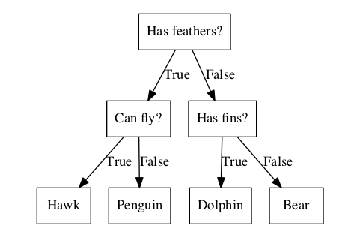

In [8]:
mglearn.plots.plot_animal_tree()

### 決定木の構築
- 決定木における学習は、正解に最も速くたどり着けるような一連のYes/No型の質問の学習を意味する
    - 機械学習においてこれらの質問は「テスト」と呼ばれる
- 通常データの特徴量は2次元データセットの用に連続値となっている
    - 連続値に対するテストは「特徴量iは値αよりも大きいか?」という形をとる
- アルゴリズムは全ての可能なテストの中から、目的変数に対して最も情報量の多いものを選ぶ 
- データの再帰分割は、対象の領域(決定木の葉)に一つの対象値(1クラスもしくは1つの回帰値)しか含まれなくなるまで繰り返す
    - 一つの対象値のデータポイントしかふくまないような決定木の葉を「純粋(pure)」と呼ぶ

### 決定木の複雑さの制御
- 葉が純粋になるまで分割を続けるとモデルは複雑になりすぎ、訓練データに対して大幅に過剰適合してしまう
- 過剰適合を防ぐには2つの戦略がある

#### 1.事前枝刈り(pre-pruning)
- 構築過程で木の生成を早めに止める
- 木の深さを制限する、葉の最大値を制限する、分割する際にその中に含まれている点の最小数を決めておくなどの方法がある

#### 2.事後枝刈り(post-pruning) ※ ただの枝刈りとも呼ばれる
- 一度木を構築してから、情報量の少ないノードを削除する


### scikit-learnの決定木
- scikit-learnでは決定木は「DecisionTreeRegressor」クラスと「DecisionTreeClassifier」クラスがある
- scikit-learnには事前枝刈りしか実装されていない

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test,  y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


- 決定木の深さに制約を与えないと決定木はいくらでも深く、複雑になる。したがって、枝刈りされていない木は過剰適合になりやすく、新しいデータに対する汎化性能が低い傾向にある

#### 深さに制限をつける

In [13]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


- max_depth=4とし、木の深さに制限を掛ける
- 訓練セットに対する精度は下がるがテストデータに対する精度は向上する

### 決定木の解析
- treeモジュールのexport_graphviz関数を使うことで木を可視化できる
    - 正しくはexport_graphvizで「.dot」ファイルを書き出すことができる

In [15]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

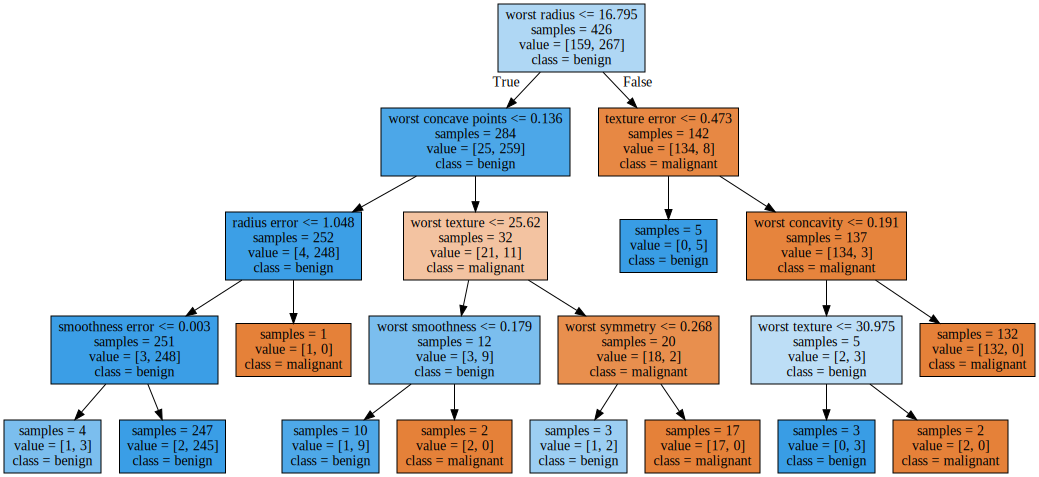

In [16]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 決定木の特徴量の重要性
- 決定木全体をみるのは大変なので、決定木から導出できる、決定木の挙動を要約する特性値をみてみる
- 要約に最もよく使われるのは、「特徴量の重要度(feature importance)」と呼ばれる
    - 決定木が行う判断にとって、個々の特徴量がどの程度重要なのかを示す割合
    - それぞれの特徴量に対する0と1の間の数
        - 0 => 「全くつかわれていない」
        - 1 => 「完全にターゲットを予想できる」

#### 特徴量の重要度をログに表示

In [18]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


#### 重要度をグラフに表示

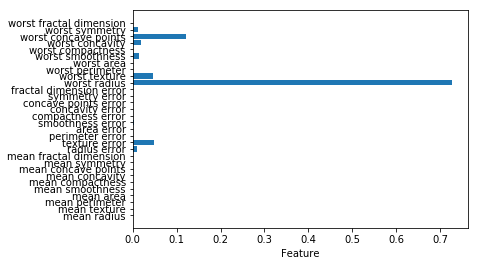

In [26]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.xlabel("Feature")
plot_feature_importances_cancer(tree)

- 最初の分岐に用いた特徴量「worst radius」が群を抜いて重要だということがわかる
    - 最初のレベルで2つのクラスがかなりきれいに分離できているという観察結果と一致
- しかし、ある特徴量の重要度(feature_importance_)の値が低いからといって、その特徴量の持つ情報が少ないとは限らない
    - 単純にその決定木で採用されなかっただけ
    - 特徴量の重要度はサンプルが良性か悪性かを判断する上で「worst radius」が重要だということを教えてくれているだけ

Feature importances: [0. 1.]


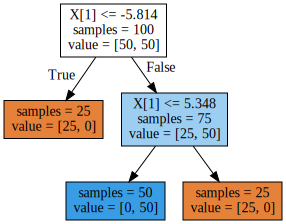

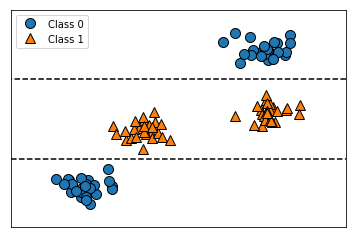

In [29]:
from IPython.display import display
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

- 上記は2つの特徴量を持つ２つのクラスからなるデータセットを示している
- ここでは全ての情報はX[1]にあるX[0]は使われていない
- しかし、「X[1] の値が大きいとクラス0になり、小さいとクラス1となる」というわけではない

### 回帰決定木(DecisionTreeRegressor)
- 使い方はほとんど分類と同じ
- 注意点として決定木によるモデルを回帰に使う際は「外挿(extrapolate)」ができない
    - つまり訓練データのレンジの外側に対して予測ができない

#### 例: 計算機のメモリ価格の履歴データ

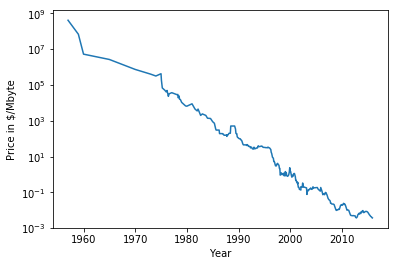

In [32]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

- y軸は対数スケールになっている

#### 2000年以降の価格の予想

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# 過去のデータを用いて2000年以降の価格を予想する

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 日付に基いて価格を予想
X_train = data_train.date[:, np.newaxis]
# データとターゲットの関係を単純にするために対数変換
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 全ての価格を予想
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

In [ ]:
iplt.semilogy(data_train.date, data_train.price, label="Training data")
  plt.semilogy(data_test.date, data_test.price, label="Test data")
  plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
  plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
  plt.legend()